In [5]:
# 2. Load the uploaded CSV data
file_name = 'PNFIIPES.csv'

try:
    # Read the CSV without specifying the date column header initially
    data = pd.read_csv(file_name)

    # --- FIND THE CORRECT DATE COLUMN ---
    # The first column is usually the Date, regardless of the header name
    date_col = data.columns[0]

    # Set the first column as the index and convert it to datetime objects
    data.set_index(date_col, inplace=True)
    data.index = pd.to_datetime(data.index)

    # --- RENAME AND CLEANUP ---
    # The second column is the value column (PNFIIPES)
    # Rename the value column for clarity
    data.rename(columns={data.columns[0]: 'ICT_Investment_Billions'}, inplace=True)

    # Select the single column needed for the ARIMA model and remove missing values
    data = data[['ICT_Investment_Billions']].dropna()

    print("--- Data Loading Successful ---")
    print(f"Date column found and set as index: {date_col}")
    print(data.head())
    print(f"\nData Shape: {data.shape}")

except FileNotFoundError:
    print(f"ERROR: The file '{file_name}' was not found. Please ensure it is uploaded to Colab.")
except Exception as e:
    print(f"An unexpected error occurred during processing: {e}")

--- Data Loading Successful ---
Date column found and set as index: observation_date
                  ICT_Investment_Billions
observation_date                         
1992-01-01                      15.781080
1992-04-01                       7.669903
1992-07-01                       8.697742
1992-10-01                      12.595060
1993-01-01                      21.615420

Data Shape: (133, 1)


# EDA

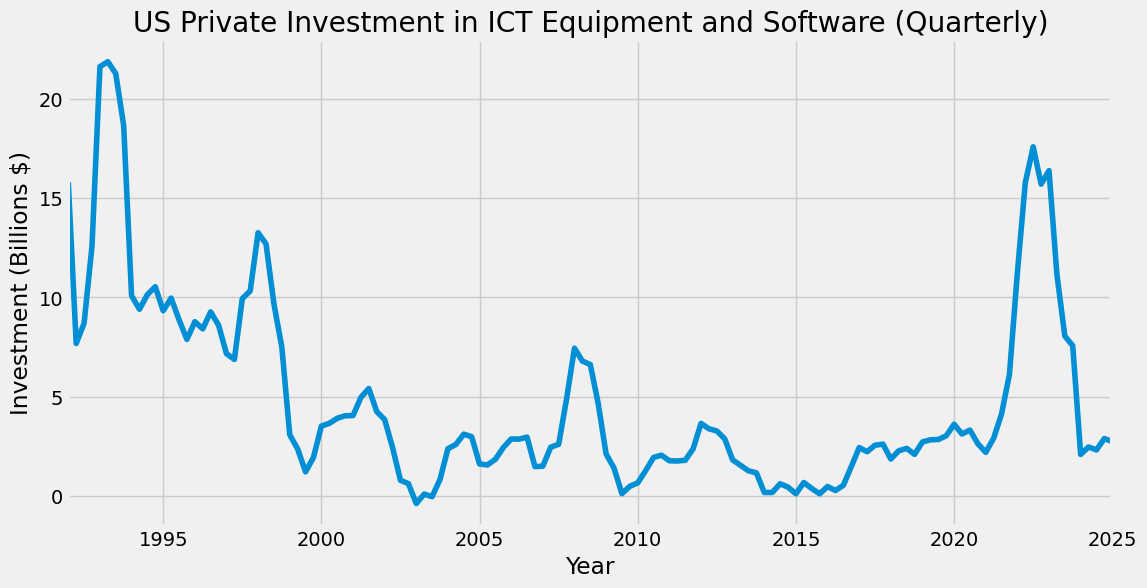

In [7]:
# 1. Plot the raw time series data
plt.figure(figsize=(12, 6))
data['ICT_Investment_Billions'].plot(title='US Private Investment in ICT Equipment and Software (Quarterly)')
plt.xlabel("Year")
plt.ylabel("Investment (Billions $)")
plt.grid(True)
plt.show()

In [8]:
# 2. Define ADF Test Function and Run Test on RAW Data
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """Performs the ADF test and returns the p-value."""
    # .dropna() is critical for ADF test
    result = adfuller(series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result[1]

print("\n--- ADF Test on RAW Data (ICT_Investment_Billions) ---")
p_value_raw = adf_test(data['ICT_Investment_Billions'])

# Determine initial d value
d_value = 0
if p_value_raw > 0.05:
    print("\nResult: Data is NOT stationary (p-value > 0.05). Differencing is needed.")
    d_value = 1
else:
    print("\nResult: Data IS stationary (p-value <= 0.05). d=0.")


--- ADF Test on RAW Data (ICT_Investment_Billions) ---
ADF Statistic: -2.393098
p-value: 0.143694
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579

Result: Data is NOT stationary (p-value > 0.05). Differencing is needed.


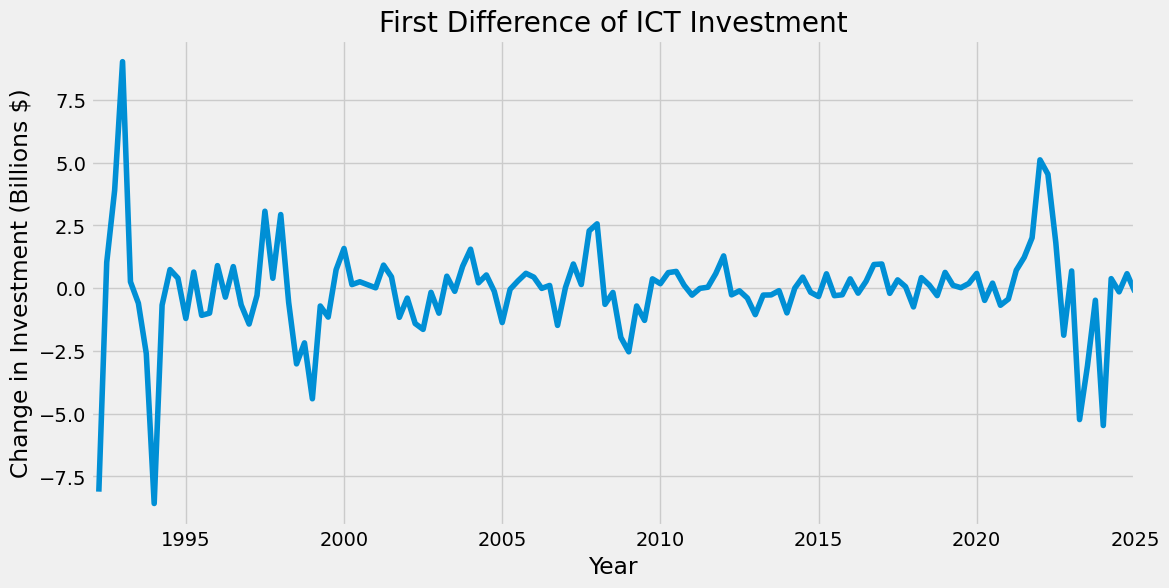


--- ADF Test on DIFFERENCED Data (d=1) ---
ADF Statistic: -6.359883
p-value: 0.000000
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579

SUCCESS: Data is now stationary. Proceeding with d=1.


In [9]:
# 3. Apply Differencing (if d=1) and Check Stationarity again
if d_value == 1:
    # Create the differenced series: This series now represents the 'quarter-over-quarter change'
    data['ICT_Investment_Diff'] = data['ICT_Investment_Billions'].diff(periods=1)

    # Plot the differenced series (it should look much flatter and fluctuate around zero)
    plt.figure(figsize=(12, 6))
    data['ICT_Investment_Diff'].plot(title='First Difference of ICT Investment')
    plt.xlabel("Year")
    plt.ylabel("Change in Investment (Billions $)")
    plt.grid(True)
    plt.show()

    # Run ADF test on the differenced data to confirm d=1
    print("\n--- ADF Test on DIFFERENCED Data (d=1) ---")
    p_value_diff = adf_test(data['ICT_Investment_Diff'])

    if p_value_diff <= 0.05:
        print("\nSUCCESS: Data is now stationary. Proceeding with d=1.")
    else:
        print("\nWARNING: Data is still not stationary. You might need a second difference (d=2).")
        # For this project, proceed with d=1 if the p-value is close, or try d=2 if the p-value is still very high.



Stationary Series (d=1) selected for ACF/PACF analysis.


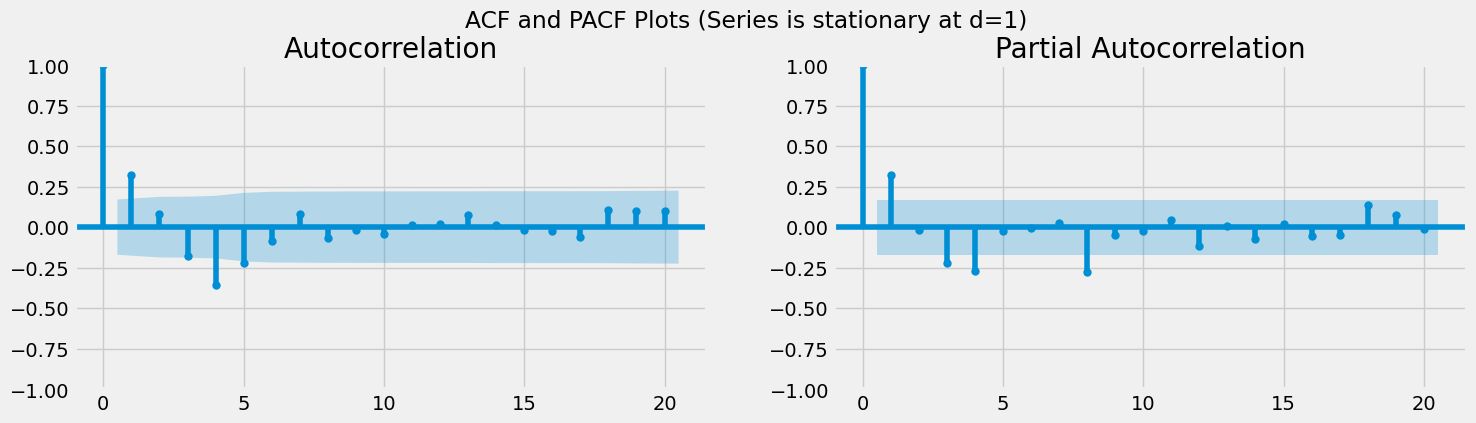


--- Analyze the plots ---
p (PACF): Look for the lag where the blue line first drops out of the shaded area.
q (ACF): Look for the lag where the blue line first drops out of the shaded area.


In [10]:
# 1. Select the stationary series (d=1 confirmed)
stationary_series = data['ICT_Investment_Diff'].dropna()
d_value = 1 # Confirmed from ADF test

print(f"\nStationary Series (d={d_value}) selected for ACF/PACF analysis.")

# 2. Plot ACF and PACF to find p and q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plt.suptitle(f'ACF and PACF Plots (Series is stationary at d={d_value})', y=1.02)

# ACF Plot: Determines q (Moving Average term)
plot_acf(stationary_series, lags=20, ax=axes[0])

# PACF Plot: Determines p (Autoregressive term)
plot_pacf(stationary_series, lags=20, ax=axes[1])

plt.show()

print("\n--- Analyze the plots ---")
print("p (PACF): Look for the lag where the blue line first drops out of the shaded area.")
print("q (ACF): Look for the lag where the blue line first drops out of the shaded area.")

In [11]:
# 1. Set the final ARIMA parameters
p_value = 1
d_value = 1 # Confirmed from ADF Test
q_value = 0 # Determined from ACF/PACF plots
print(f"\nFinal ARIMA Order Selected: ARIMA({p_value}, {d_value}, {q_value})")

# 2. Split Data (Using the original, non-differenced series)
test_size = 8  # 8 quarters = 2 years for testing
train_data = data['ICT_Investment_Billions'][:-test_size]
test_data = data['ICT_Investment_Billions'][-test_size:]

print(f"Training Data Length: {len(train_data)}")
print(f"Testing Data Length: {len(test_data)}")


Final ARIMA Order Selected: ARIMA(1, 1, 0)
Training Data Length: 125
Testing Data Length: 8


In [12]:
# 3. Fit the ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

print("\n--- Fitting ARIMA Model ---")
try:
    # Use the raw series, but specify the (p, d, q) order
    model = ARIMA(train_data, order=(p_value, d_value, q_value))
    model_fit = model.fit()
    print(model_fit.summary())

    # 4. Make predictions on the test set
    forecast_results = model_fit.get_forecast(steps=test_size)
    forecast_test = forecast_results.predicted_mean

    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(test_data, forecast_test))
    print(f"\nValidation Complete. RMSE (Model Error) on Test Set: {rmse:.2f} Billion")

except Exception as e:
    print(f"ERROR: Could not fit model. Error: {e}")


--- Fitting ARIMA Model ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                  
Dep. Variable:     ICT_Investment_Billions   No. Observations:                  125
Model:                      ARIMA(1, 1, 0)   Log Likelihood                -243.323
Date:                     Wed, 29 Oct 2025   AIC                            490.646
Time:                             21:31:41   BIC                            496.287
Sample:                         01-01-1992   HQIC                           492.938
                              - 01-01-2023                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3948      0.048      8.222      0.000       0.301       0.489
sigma2         2.9604      0.200     14.831      0.000       2.569       3.352
Ljung-Box (L

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


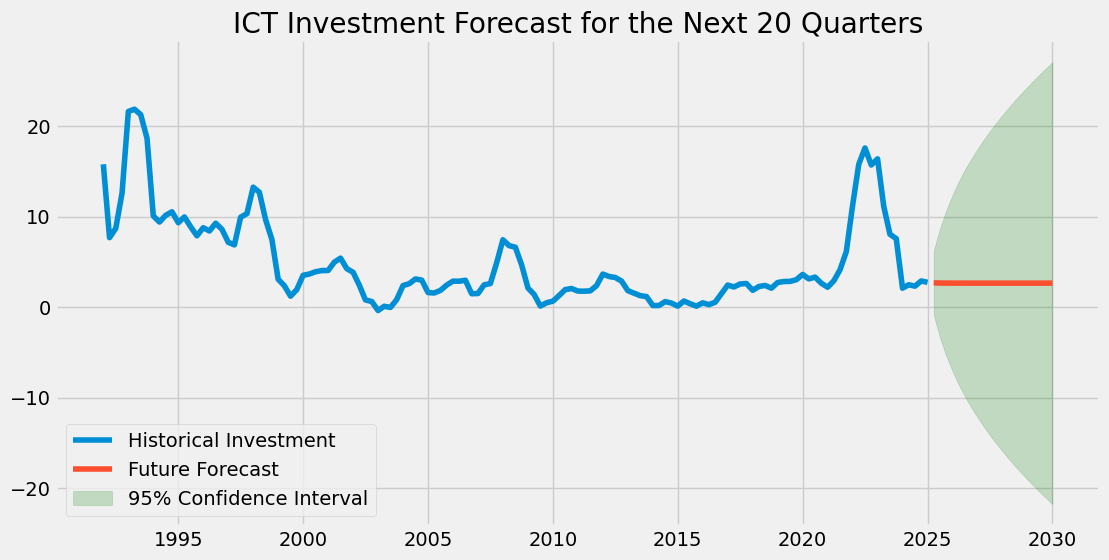

In [13]:
# 1. Final Long-Term Forecast
forecast_periods = 20 # 20 quarters = 5 years

# Retrain on all available data for the most robust forecast
final_model = ARIMA(data['ICT_Investment_Billions'], order=(1, 1, 0)).fit()

# Get the forecast for the next 20 steps
final_forecast_results = final_model.get_forecast(steps=forecast_periods)
final_forecast_series = final_forecast_results.predicted_mean
final_conf_int = final_forecast_results.conf_int(alpha=0.05)

# 2. Final Forecast Visualization
plt.figure(figsize=(12, 6))
plt.plot(data['ICT_Investment_Billions'], label='Historical Investment')
plt.plot(final_forecast_series, label='Future Forecast')
plt.fill_between(final_conf_int.index,
                 final_conf_int.iloc[:, 0], # Lower bound
                 final_conf_int.iloc[:, 1], # Upper bound
                 color='green', alpha=0.2, label='95% Confidence Interval')
plt.title(f'ICT Investment Forecast for the Next {forecast_periods} Quarters')
plt.legend()
plt.show()